<a href="https://colab.research.google.com/github/goransavich/cnn-xgboost/blob/main/cnn_duble_xgboost_cvgrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
np.random.seed(1337)  # for reproducibility
#from keras.utils import np_utils
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Convolution1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.utils import shuffle
from keras.layers.merge import concatenate
#xgboost
import xgboost as xgb
import pandas as pd
from sklearn import metrics

In [74]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd

train_name = list(uploaded.keys())[0]

train_df = pd.read_csv(io.BytesIO(uploaded[train_name]))

Saving BeetleFly_TRAIN.csv to BeetleFly_TRAIN (2).csv


In [75]:
uploaded = files.upload()

test_name = list(uploaded.keys())[0]

test_df = pd.read_csv(io.BytesIO(uploaded[test_name]))

Saving BeetleFly_TEST.csv to BeetleFly_TEST (2).csv


In [76]:
train_data = np.array(train_df)
test_data = np.array(test_df)
#train_data, test_data = shuffle(train_data, test_data)

In [77]:
x_train = train_data[:, :-1]
x_test = test_data[:, :-1]
train_y = train_data[:, -1:] 
test_y = test_data[:, -1:]

count_train = np.unique(train_y, return_counts=True)
count_test = np.unique(test_y, return_counts=True)

print(count_train[1])
print(count_test[1])

classes_in_dataset = len(np.unique(np.concatenate((train_y, test_y), axis=0)))

# transform the labels from integers to one hot vectors
enc = OneHotEncoder(categories='auto')
enc.fit(np.concatenate((train_y, test_y), axis=0).reshape(-1, 1))
y_train = enc.transform(train_y.reshape(-1, 1)).toarray()
y_test = enc.transform(test_y.reshape(-1, 1)).toarray()

x_train.shape
x_test.shape

[10 10]
[10 10]


(20, 512)

In [78]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.1,random_state = 42)

In [79]:
if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension 
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
input_shape = x_train.shape[1:]

print(input_shape)

print('Number of classes : {}'.format(classes_in_dataset))
###y_train for xgboost without encoding
y_train_xgboost = enc.inverse_transform(y_train)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(512, 1)
Number of classes : 2
(18, 512, 1)
(18, 2)
(20, 512, 1)
(20, 2)
(2, 512)
(2, 2)


In [80]:
inputs = input_shape
input_layer = Input(inputs)

###################### first feature extractor #####################
conv1d1 = Convolution1D(filters=6, kernel_size=7, padding='valid')(input_layer)
activation1d1 = Activation('sigmoid')(conv1d1)
maxpooling1d1 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation1d1)
#dropout1 = Dropout(0.3)(maxpooling1)

conv1d2 = Convolution1D(filters=12, kernel_size=7, padding='valid')(maxpooling1d1)
activation1d2 = Activation('sigmoid')(conv1d2)
maxpooling1d2 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation1d2)
#dropout1d1 = Dropout(0.3)(maxpooling1d2)
flatten1 = Flatten()(maxpooling1d2)
###################### second feature extractor #####################

conv2d1 = Convolution1D(filters=6, kernel_size=7, padding='valid')(input_layer)
activation2d1 = Activation('sigmoid')(conv2d1)
maxpooling2d1 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation2d1)
#dropout1 = Dropout(0.3)(maxpooling2d1)

conv2d2 = Convolution1D(filters=12, kernel_size=7, padding='valid')(maxpooling2d1)
activation2d2 = Activation('sigmoid')(conv2d2)
maxpooling2d2 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation2d2)
#dropout1d2 = Dropout(0.3)(maxpooling2d2)
flatten2 = Flatten()(maxpooling2d2)

##################### concatenate ###################################
flatten = concatenate([flatten1, flatten2])

dense1 = Dense(512)(flatten) ##kernel_regularizer=l2(0.001)
activation3 = Activation('sigmoid')(dense1)

dense2 = Dense(units=classes_in_dataset)(activation3)
activation4 = Activation('softmax')(dense2)

output_for_xgboost = Model(inputs=input_layer, outputs=flatten)
model = Model(inputs=input_layer, outputs=activation4)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.compile(loss ='mean_squared_error', optimizer='Adam',metrics =['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=400,
    verbose=1,
    #callbacks=[callback],
    validation_data=(x_validate,y_validate),
)

score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))


Epoch 1/400
3/3 [==============================] - 1s 275ms/step - loss: 0.4697 - accuracy: 0.3889 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/400
3/3 [==============================] - 0s 82ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/400
3/3 [==============================] - 0s 83ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 4/400
3/3 [==============================] - 0s 85ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 5/400
3/3 [==============================] - 0s 82ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 6/400
3/3 [==============================] - 0s 77ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 7/400
3/3 [==============================] - 0s 81ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 8/400
3/3 [==

Text(0.5, 1.0, 'Train - Accuracy')

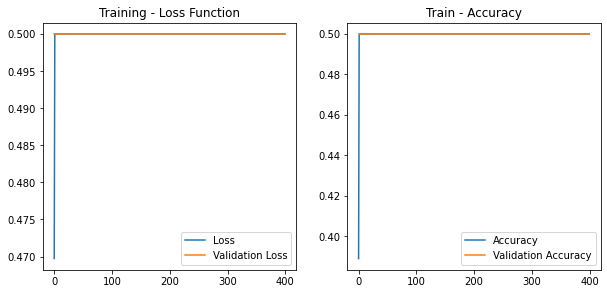

In [81]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [82]:
######### XGBOOST #############

intermediate_layer_model = output_for_xgboost

intermediate_layer_model.summary()

x_train_xgboost = intermediate_layer_model.predict(x_train)
x_test_xgboost = intermediate_layer_model.predict(x_test)

#label encoder for y to be in range from 0 to num-classes
def transform_labels(y_train_xgboost, test_y):
    le = preprocessing.LabelEncoder()
    y_t_xgboost = le.fit_transform(y_train_xgboost)
    t_y = le.fit_transform(test_y)
    return y_t_xgboost, t_y

y_tr_xgboost, test_y_xgboost = transform_labels(y_train_xgboost, test_y)

xgboost_train_dataset = np.concatenate([np.array(x_train_xgboost).reshape(x_train.shape[0],flatten.shape[1]),np.array(y_tr_xgboost).reshape(y_tr_xgboost.shape[0],1)],axis=1)
xgboost_train_dataset = pd.DataFrame(xgboost_train_dataset)
xgboost_train_dataset.to_csv('train_xgboost.csv',index=False)

xgboost_test_dataset = np.concatenate([np.array(x_test_xgboost).reshape(x_test.shape[0],flatten.shape[1]),np.array(test_y_xgboost).reshape(test_y_xgboost.shape[0],1)],axis=1)
xgboost_test_dataset = pd.DataFrame(xgboost_test_dataset)
xgboost_test_dataset.to_csv('test_xgboost.csv',index=False)

train_column = str(flatten.shape[1])

train = pd.read_csv('train_xgboost.csv')
train_y = train[train_column].astype('int')
train_x = train.drop([train_column],axis=1)

test = pd.read_csv('test_xgboost.csv')
test_y = test[train_column].astype('int')
test_x = test.drop([train_column],axis=1)

print(train_y.shape)
print(test_y.shape)

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
parameters_grid=[{'eta':[0.1,0.2,0.3,0.4],
                  'max_depth':[3,4,5,6,7,8],
                  'lambda':[0,1,10]}]

estimator = XGBClassifier(
    nthread=4,
    seed=42
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters_grid,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 4,
    verbose=True
)
     
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
#watchlist = [(dataset, 'train')]
#params = {'max_depth':5, 'eta':0.3, 'silent':1,  'num_class': classes_in_dataset} 
model_xg = grid_search.fit(train_x, train_y)

model_xg.best_params_
print(model_xg.best_params_)
#test_x = xgb.DMatrix(test_x)
result = model_xg.predict(test_x)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 506, 6)       48          input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 506, 6)       48          input_8[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 506, 6)       0           conv1d_24[0][0]                  
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(18,)
(20,)
Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   21.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 288 out of 288 | elapsed:  3.0min finished


{'eta': 0.1, 'lambda': 0, 'max_depth': 3}


In [83]:

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

#preds = model.predict(d_test)
#best_preds = np.asarray([np.argmax(line) for line in result])

print("Precision = {}".format(precision_score(test_y, result, average='macro', zero_division=0)))
print("Recall = {}".format(recall_score(test_y, result, average='macro', zero_division=0)))
print("Accuracy = {}".format(accuracy_score(test_y, result)))
print("F1 score = {}".format(f1_score(test_y, result, average='macro', zero_division=0)))

print(metrics.classification_report(test_y, result))
print(metrics.confusion_matrix(test_y, result))

Precision = 0.7747252747252746
Recall = 0.75
Accuracy = 0.75
F1 score = 0.7442455242966751
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20

[[9 1]
 [4 6]]
